In [60]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import skimage
from skimage import measure
import random
import pandas as pd
import functions

In [61]:
img = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/nifti/Image_LIDC_IDRI_0001.nii.gz")
label = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/nifti/Label_LIDC_IDRI_0001.nii.gz")
mask = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/nifti/Lung_mask_LIDC_IDRI_0001.nii.gz")

In [62]:

print(img.get_data_dtype())
test_numpy_image = np.asanyarray(img.dataobj, dtype=np.int16)
print(test_numpy_image.dtype)
print(test_numpy_image.shape)
#img.shape

affine = img.affine
print(affine)

int16
int16
(360, 360, 332)
[[  -0.703125      0.            0.          166.        ]
 [  -0.            0.703125      0.         -187.59687805]
 [   0.           -0.            2.5        -340.        ]
 [   0.            0.            0.            1.        ]]


In [63]:
#turning images into numpy array and keeping the images as an int16

np_img = np.asanyarray(img.dataobj, dtype=np.int16)
np_mask = np.asanyarray(mask.dataobj, dtype=np.int16)
np_label = np.asanyarray(label.dataobj, dtype=np.int16)

print(np_img.shape)
print(np_mask.shape)
print(np_label.shape)

print(np_img.dtype)
print(np_mask.dtype)
print(np_label.dtype)

(360, 360, 332)
(360, 360, 332)
(360, 360, 332)
int16
int16
int16


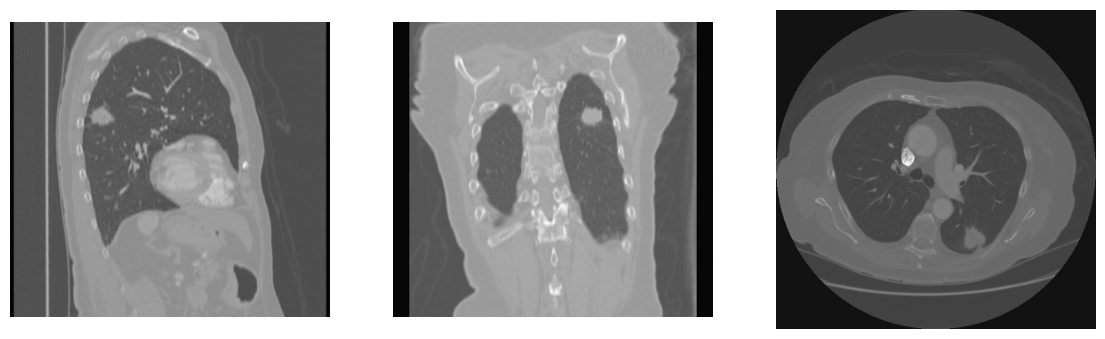

In [19]:
slicez = np_img[220, :, :]
slicey = np_img[:, 100, :]
slicex = np_img[:, :, 225]

slices = [slicez, slicey, slicex]

fig, axes = plt.subplots(1, 3, figsize=(14, 21))
for i, s in enumerate(slices):
    axes[i].imshow(np.flipud(s.T), cmap='gray')
    axes[i].axis("off")

In [20]:
unique_vals = np.unique(np_img)
print(unique_vals)

[-2465 -2463 -2461 ...  3748  3772  3787]


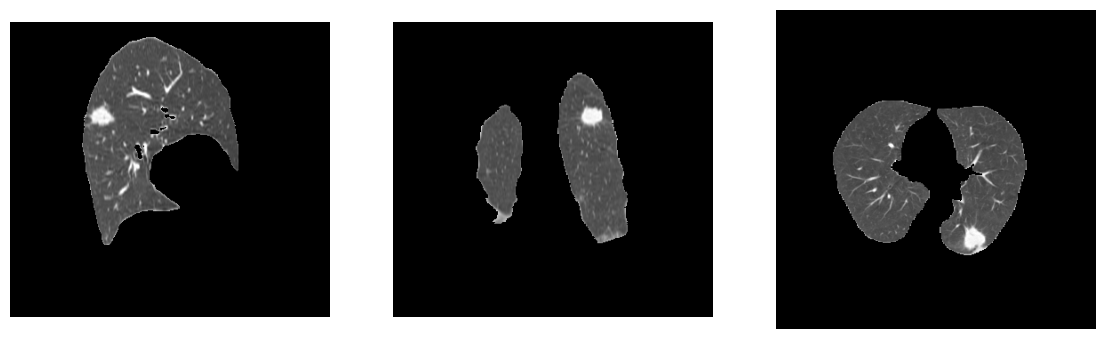

In [ ]:
#preprocessing of the scans
np_img = functions.apply_windowing(np_img, 1500, -600)
np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
binary = np_mask > 0
masked_img = binary * np_img
np_img = np_img.astype(np.float32)
np_label = np_label.astype(np.float32)


slicez = masked_img[220, :, :]
slicey = masked_img[:, 100, :]
slicex = masked_img[:, :, 225]

slices = [slicez, slicey, slicex]

fig, axes = plt.subplots(1, 3, figsize=(14, 21))
for i, s in enumerate(slices):
    axes[i].imshow(np.flipud(s.T), cmap='gray')
    axes[i].axis("off")

In [65]:
print(masked_img.shape)

print(masked_img.max())
print(masked_img.min())

print(np_img.max())
print(np_img.min())

print(np.percentile(masked_img, [1, 99]))

(360, 360, 332)
1.0
0.0
1.0
0.0
[0.         0.41133333]


In [66]:
labels = measure.label(np_label, connectivity=1)
props = measure.regionprops(labels)

for prop in props:
    print("Label:", prop.label)
    print("Volume:", prop.area)            # number of voxels
    print("Centroid:", prop.centroid)      # (z, row, col)
    print("Bounding box:", prop.bbox)      # (min_z, min_row, min_col, max_z, max_row, max_col)


Label: 1
Volume: 6659.0
Centroid: (222.20648746057967, 101.13155128397658, 224.6936476948491)
Bounding box: (211, 88, 215, 236, 117, 235)


In [67]:
print(props[0].centroid[0])

patch3d = masked_img[props[0].bbox[0]:props[0].bbox[3], props[0].bbox[1]:props[0].bbox[4], props[0].bbox[2]:props[0].bbox[5]]

222.20648746057967


(29, 20)
(25, 20)
(25, 29)


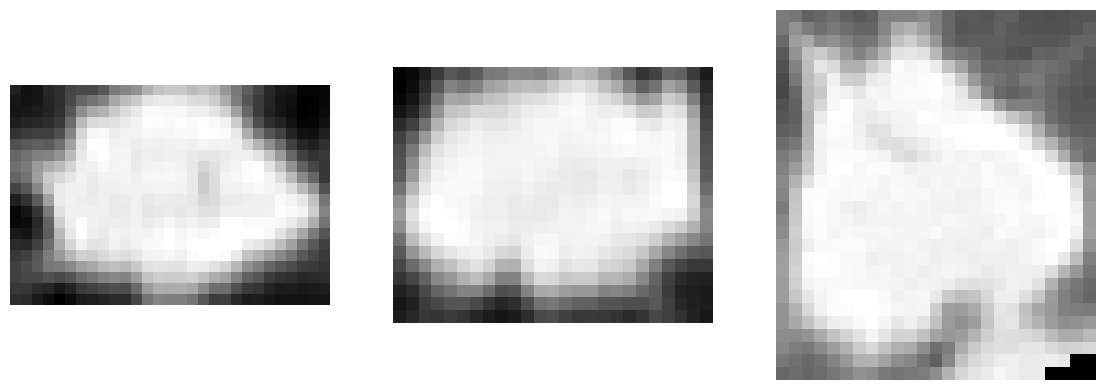

In [68]:
slicez = patch3d[10, :, :]
slicey = patch3d[:, 10, :]
slicex = patch3d[:, :, 10]

slices = [slicez, slicey, slicex]

fig, axes = plt.subplots(1, 3, figsize=(14, 21))
for i, s in enumerate(slices):
    print(s.shape)
    axes[i].imshow(np.flipud(s.T), cmap='gray')
    axes[i].axis("off")

In [69]:
#getting 2D patches

#variables

half_patch_size = 32

#to change slice view change the range in loop, the slice axis and the name of the file when saving    

#going over each axial slice
for slice_num in range(masked_img.shape[2]):

    img_slice = masked_img[:, :, slice_num]
    label_slice = np_label[:, :, slice_num]

    #getting the labels
    labels = measure.label(label_slice, connectivity=1)

    #getting regionprops if there is lesion in slice
    if labels.max() != 0:

        props = measure.regionprops(labels)

        #going over the regions
        for prop in props:

            #check is the region is larger than 3 pixels
            if prop.area > 3:

                #check if the region plus the added number are within image bounds
                if prop.centroid[0] - 47 > 0 and prop.centroid[0] + 47 < img_slice.shape[0] and prop.centroid[1] - 47 > 0 and prop.centroid[1] + 47 < img_slice.shape[1]:
                    
                    #create 5 patches per slice
                    for reps in range(5):

                        #get a random deviation from the centroid
                        y_drift = random.randint(-15, 15)
                        x_drift = random.randint(-15, 15)

                        #crop the image to a patch of size 64 with the centroid in the middle and a random drift
                        img_patch2d = img_slice[int(prop.centroid[0])-half_patch_size+y_drift : int(prop.centroid[0])+half_patch_size+y_drift , int(prop.centroid[1])-half_patch_size+x_drift : int(prop.centroid[1])+half_patch_size+x_drift]
                        label_patch2d = label_slice[int(prop.centroid[0])-half_patch_size+y_drift : int(prop.centroid[0])+half_patch_size+y_drift , int(prop.centroid[1])-half_patch_size+x_drift : int(prop.centroid[1])+half_patch_size+x_drift]
                        
                        #random flipping of the images for a more diverse dataset
                        if random.randint(0, 1) == 0:
                            img_patch2d = np.fliplr(img_patch2d)
                            label_patch2d = np.fliplr(label_patch2d)
                        if random.randint(0, 1) == 0:
                            img_patch2d = np.flipud(img_patch2d)
                            label_patch2d = np.flipud(label_patch2d)

                        #save the images as .npy
                        img_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/images/image_1_" + str(slice_num) + "_" + str(reps+1) + ".npy"
                        label_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/labels/image_1_" + str(slice_num) + "_" + str(reps+1) + ".npy"
                        np.save(img_path, img_patch2d)
                        np.save(label_path, label_patch2d)
                        
                        '''#visualizing patches code
                        plt.figure()
                        plt.imshow(np.flipud(img_patch2d.T), cmap='gray')
                        plt.axis("off")
                        plt.figure()
                        plt.imshow(np.flipud(label_patch2d.T), cmap='gray')
                        plt.axis("off")'''
                        #break
    #break  

In [70]:
image = np.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/images/image_1_215_1.npy").astype(np.float32)
print(image.shape)

(64, 64)


In [ ]:
img = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/nifti/Image_LIDC_IDRI_0011.nii.gz")
label = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/nifti/Label_LIDC_IDRI_0011.nii.gz")
mask = nib.load("/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/nifti/Lung_mask_LIDC_IDRI_0011.nii.gz")

np_img = np.asanyarray(img.dataobj, dtype=np.int16)
np_mask = np.asanyarray(mask.dataobj, dtype=np.int16)
np_label = np.asanyarray(label.dataobj, dtype=np.int16)

#preprocessing of the scans
np_img = functions.apply_windowing(np_img, 1500, -600)
np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
binary = np_mask > 0
masked_img = binary * np_img
np_img = np_img.astype(np.float32)
np_label = np_label.astype(np.float32)

In [72]:
labels = measure.label(np_label, connectivity=1)
props = measure.regionprops(labels)

for prop in props:
        if prop.area > 3:
                print("Label:", prop.label)
                print("Volume:", prop.area)            # number of voxels
                print("Centroid:", prop.centroid)      # (z, row, col)
                print("Bounding box:", prop.bbox)      # (min_z, min_row, min_col, max_z, max_row, max_col)

Label: 1
Volume: 433.0
Centroid: (81.87066974595842, 133.29792147806003, 71.84295612009238)
Bounding box: (79, 130, 66, 86, 138, 78)
Label: 2
Volume: 686.0
Centroid: (117.15889212827989, 143.83673469387756, 261.9256559766764)
Bounding box: (110, 140, 255, 125, 149, 271)


In [73]:
properties = ['label', 'area', 'centroid', 'bbox']
table = pd.DataFrame(measure.regionprops_table(labels, properties=properties)).reset_index()
print(table)

   index  label   area  centroid-0  centroid-1  centroid-2  bbox-0  bbox-1  \
0      0      1  433.0   81.870670  133.297921   71.842956      79     130   
1      1      2  686.0  117.158892  143.836735  261.925656     110     140   

   bbox-2  bbox-3  bbox-4  bbox-5  
0      66      86     138      78  
1     255     125     149     271  


In [74]:
#getting 3D patches

half_patch_size = 32

    
#getting the labels
labels = measure.label(np_label, connectivity=1)

#getting regionprops if there is lesion in scan
if labels.max() != 0:

    props = measure.regionprops(labels)

    #going over the regions
    for prop in props:

        #check is the region is larger than 3 pixels
        if prop.area > 3:

            #check if the region plus the added number are within image bounds
            if prop.centroid[0] - 47 > 0 and prop.centroid[0] + 47 < masked_img.shape[0] and prop.centroid[1] - 47 > 0 and prop.centroid[1] + 47 < masked_img.shape[1] and prop.centroid[2] - 47 > 0 and prop.centroid[2] + 47 < masked_img.shape[2]:
                
                #create 20 patches per scan
                for reps in range(20):

                    #get a random deviation from the centroid
                    z_drift = random.randint(-15, 15)
                    y_drift = random.randint(-15, 15)
                    x_drift = random.randint(-15, 15)

                    #crop the image to a patch of size 64 with the centroid in the middle and a random drift
                    img_patch3d = masked_img[int(prop.centroid[0])-half_patch_size+z_drift : int(prop.centroid[0])+half_patch_size+z_drift, int(prop.centroid[1])-half_patch_size+y_drift : int(prop.centroid[1])+half_patch_size+y_drift , int(prop.centroid[2])-half_patch_size+x_drift : int(prop.centroid[2])+half_patch_size+x_drift]
                    label_patch3d = np_label[int(prop.centroid[0])-half_patch_size+z_drift : int(prop.centroid[0])+half_patch_size+z_drift, int(prop.centroid[1])-half_patch_size+y_drift : int(prop.centroid[1])+half_patch_size+y_drift , int(prop.centroid[2])-half_patch_size+x_drift : int(prop.centroid[2])+half_patch_size+x_drift]
                    
                    #random flipping of the images for a more diverse dataset
                    if random.randint(0, 1) == 0:
                        img_patch3d = np.flip(img_patch3d, axis=0)
                        label_patch3d = np.flip(label_patch3d, axis=0)
                    if random.randint(0, 1) == 0:
                        img_patch3d = np.flip(img_patch3d, axis=1)
                        label_patch3d = np.flip(label_patch3d, axis=1)
                    if random.randint(0, 1) == 0:
                        img_patch3d = np.flip(img_patch3d, axis=2)
                        label_patch3d = np.flip(label_patch3d, axis=2)

                    #save the images as .npy in different folders for train, validation and test
                    
                    img_64_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/3D/images/image_11_" + str(reps+1) + ".npy"
                    label_64_path = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/3D/labels/image_11_" + str(reps+1) + ".npy"
                        
                    np.save(img_64_path, img_patch3d)
                    np.save(label_64_path, label_patch3d)
                    #break
#break